In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [2]:
from configuration import Config
from dataset import train_dataset, valid_dataset, test_dataset
from model import DIP

In [3]:
# 하이퍼 파라미터들
C = Config()

valid_sample_num = C.get('valid_sample_num')
test_sample_num = C.get('test_sample_num')

device = C.get('device')
input_size = C.get('input_size')
hidden_size = C.get('hidden_size')
output_size = C.get('output_size')

batch_size = C.get('batch_size')
num_workers = C.get('num_workers')
lr = C.get('lr')
weight_decay = C.get('weight_decay')

epochs = C.get('epochs')
clip_grad = C.get('clip_grad')
print_every = C.get('print_every')

In [4]:
# 데이터 불러오기
train_acc, train_smpl, train_input = train_dataset()
valid_acc, valid_ori, valid_smpl = valid_dataset()
test_acc, test_ori, test_smpl = test_dataset()

In [5]:
# 모델 생성
model = DIP(input_size, hidden_size, output_size, n_layers=2, drop_prob=0.0)
model = model.to(device)
model

DIP(
  (input_layer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=60, out_features=512, bias=True)
    (2): ReLU()
  )
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (output_layer_mu): Sequential(
    (0): Linear(in_features=1024, out_features=150, bias=True)
    (1): LogSoftmax(dim=2)
  )
  (output_layer_sigma): Sequential(
    (0): Linear(in_features=1024, out_features=150, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [6]:
criterion = nn.GaussianNLLLoss() # Loss Function
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [7]:
# train 데이터셋 형성
train_dataset = TensorDataset(torch.from_numpy(train_input),
                              torch.from_numpy(train_smpl),
                              torch.from_numpy(train_acc))
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          drop_last=False,
                          shuffle=True)

In [8]:
# validation 데이터셋 형성
valid_input_list, valid_dataset = [], []

for i in range(valid_sample_num):
    valid_input_list.append(torch.concat((torch.tensor([valid_ori[i]]), torch.tensor([valid_acc[i]])), axis=2))
    valid_dataset.append((valid_input_list[i], torch.tensor([valid_smpl[i]]), torch.tensor([valid_acc[i]])))

In [9]:
# test 데이터셋 형성
test_input_list, test_dataset = [], []

for i in range(test_sample_num):
    test_input_list.append(torch.concat((torch.tensor([test_ori[i]]), torch.tensor([test_acc[i]])), axis=2))
    test_dataset.append((test_input_list[i], torch.tensor([test_smpl[i]]), torch.tensor([test_acc[i]])))

In [10]:
if __name__ == "__main__":
    train_losses = []
    valid_losses = []
    accuracies = []
    
    valid_min = np.inf
    
    for e in range(epochs):
        print_count = 0
        
        for train_input, train_smpl, train_acc in train_loader:
            print_count += 1
            
            train_input = train_input.to(device).float()
            train_smpl = train_smpl.to(device).float()
            train_acc = train_acc.to(device).float()
            
            h = model.init_hidden(train_input.shape[0])
            h = tuple([each.data for each in h])
            
            model.zero_grad()
            smpl_mu, acc_mu, smpl_sigma, acc_sigma = model(train_input, h)
            smpl_loss = criterion(smpl_mu, train_smpl, smpl_sigma) # 자세 추정을 위한 Loss
            acc_loss = criterion(acc_mu, train_acc, acc_sigma) # 가속도 복원을 위한 Loss
            final_loss = smpl_loss + acc_loss
            
            final_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            
            if print_count % print_every == 0:
                train_losses.append(final_loss.item())
                
                # Validation 코드 다시 작성해야함
                """
                temp_losses = []
                model.eval()
                
                for valid_input, valid_smpl, valid_acc in valid_dataset:
                    valid_input = valid_input.to(device).float()
                    valid_smpl = valid_smpl.to(device).float()
                    valid_acc = valid_acc.to(device).float()
                    
                    valid_h = model.init_hidden(valid_input.shape[0])
                    valid_h = tuple([each.data for each in valid_h])
                    
                    model.zero_grad()
                    smpl_mu, acc_mu, smpl_sigma, acc_sigma = model(valid_input, valid_h)
                    smpl_loss = criterion(smpl_mu, valid_smpl, smpl_sigma)
                    acc_loss = criterion(acc_mu, valid_acc, acc_sigma)
                    valid_final_loss = smpl_loss + acc_loss
                    
                    temp_losses.append(valid_final_loss.item())
                
                valid_loss = np.mean(temp_losses)
                valid_losses.append(valid_loss)
                
                if valid_loss < valid_min:
                    valid_min = valid_loss
                    torch.save(model.state_dict(), 'model.pt')
                """

                print("Epoch: {}/{}\t".format(e+1, epochs),
                      "Step: {}/{}\t".format(print_count, len(train_loader)),
                      "Train Loss: {:.6f}\t".format(final_loss.item()))
                      #"Valid Loss: {:.6f}".format(valid_loss))
                
            model.train()

Epoch: 1/2000	 Step: 15/54	 Train Loss: 4.948278	 Valid Loss: 5.420880
Epoch: 1/2000	 Step: 30/54	 Train Loss: 4.270013	 Valid Loss: 4.767088
Epoch: 1/2000	 Step: 45/54	 Train Loss: 4.290290	 Valid Loss: 4.665405
Epoch: 2/2000	 Step: 15/54	 Train Loss: 4.257997	 Valid Loss: 4.606669
Epoch: 2/2000	 Step: 30/54	 Train Loss: 4.214086	 Valid Loss: 4.590758
Epoch: 2/2000	 Step: 45/54	 Train Loss: 4.203246	 Valid Loss: 4.593370
Epoch: 3/2000	 Step: 15/54	 Train Loss: 4.214173	 Valid Loss: 4.609880
Epoch: 3/2000	 Step: 30/54	 Train Loss: 4.243536	 Valid Loss: 4.601630
Epoch: 3/2000	 Step: 45/54	 Train Loss: 4.424133	 Valid Loss: 4.596706
Epoch: 4/2000	 Step: 15/54	 Train Loss: 4.570402	 Valid Loss: 4.587574
Epoch: 4/2000	 Step: 30/54	 Train Loss: 4.175492	 Valid Loss: 4.583365
Epoch: 4/2000	 Step: 45/54	 Train Loss: 4.153076	 Valid Loss: 4.610445
Epoch: 5/2000	 Step: 15/54	 Train Loss: 4.212808	 Valid Loss: 4.539682
Epoch: 5/2000	 Step: 30/54	 Train Loss: 4.195412	 Valid Loss: 4.543993
Epoch:

Epoch: 39/2000	 Step: 30/54	 Train Loss: 4.176334	 Valid Loss: 4.420855
Epoch: 39/2000	 Step: 45/54	 Train Loss: 4.349921	 Valid Loss: 4.419517
Epoch: 40/2000	 Step: 15/54	 Train Loss: 4.108655	 Valid Loss: 4.405229
Epoch: 40/2000	 Step: 30/54	 Train Loss: 4.205279	 Valid Loss: 4.400505
Epoch: 40/2000	 Step: 45/54	 Train Loss: 4.208703	 Valid Loss: 4.387789
Epoch: 41/2000	 Step: 15/54	 Train Loss: 4.172663	 Valid Loss: 4.420063
Epoch: 41/2000	 Step: 30/54	 Train Loss: 4.104518	 Valid Loss: 4.419863
Epoch: 41/2000	 Step: 45/54	 Train Loss: 4.134052	 Valid Loss: 4.416978
Epoch: 42/2000	 Step: 15/54	 Train Loss: 4.199532	 Valid Loss: 4.384967
Epoch: 42/2000	 Step: 30/54	 Train Loss: 4.217034	 Valid Loss: 4.380745
Epoch: 42/2000	 Step: 45/54	 Train Loss: 4.070380	 Valid Loss: 4.382704
Epoch: 43/2000	 Step: 15/54	 Train Loss: 4.090750	 Valid Loss: 4.392191
Epoch: 43/2000	 Step: 30/54	 Train Loss: 4.061602	 Valid Loss: 4.389310
Epoch: 43/2000	 Step: 45/54	 Train Loss: 4.203986	 Valid Loss: 4

Epoch: 77/2000	 Step: 30/54	 Train Loss: 4.040817	 Valid Loss: 4.293677
Epoch: 77/2000	 Step: 45/54	 Train Loss: 4.010643	 Valid Loss: 4.294997
Epoch: 78/2000	 Step: 15/54	 Train Loss: 4.013539	 Valid Loss: 4.293667
Epoch: 78/2000	 Step: 30/54	 Train Loss: 4.042760	 Valid Loss: 4.300342
Epoch: 78/2000	 Step: 45/54	 Train Loss: 3.990843	 Valid Loss: 4.298628
Epoch: 79/2000	 Step: 15/54	 Train Loss: 3.981423	 Valid Loss: 4.297348
Epoch: 79/2000	 Step: 30/54	 Train Loss: 4.037476	 Valid Loss: 4.286177
Epoch: 79/2000	 Step: 45/54	 Train Loss: 3.997378	 Valid Loss: 4.283463
Epoch: 80/2000	 Step: 15/54	 Train Loss: 4.033975	 Valid Loss: 4.286113
Epoch: 80/2000	 Step: 30/54	 Train Loss: 3.988654	 Valid Loss: 4.303567
Epoch: 80/2000	 Step: 45/54	 Train Loss: 3.973862	 Valid Loss: 4.297772
Epoch: 81/2000	 Step: 15/54	 Train Loss: 4.007290	 Valid Loss: 4.294929
Epoch: 81/2000	 Step: 30/54	 Train Loss: 4.100029	 Valid Loss: 4.299829
Epoch: 81/2000	 Step: 45/54	 Train Loss: 4.157792	 Valid Loss: 4

Epoch: 115/2000	 Step: 30/54	 Train Loss: 3.996095	 Valid Loss: 4.261285
Epoch: 115/2000	 Step: 45/54	 Train Loss: 4.109751	 Valid Loss: 4.255563
Epoch: 116/2000	 Step: 15/54	 Train Loss: 3.983687	 Valid Loss: 4.300638
Epoch: 116/2000	 Step: 30/54	 Train Loss: 4.023596	 Valid Loss: 4.272422
Epoch: 116/2000	 Step: 45/54	 Train Loss: 3.994385	 Valid Loss: 4.309840
Epoch: 117/2000	 Step: 15/54	 Train Loss: 3.986089	 Valid Loss: 4.266768
Epoch: 117/2000	 Step: 30/54	 Train Loss: 3.961692	 Valid Loss: 4.249484
Epoch: 117/2000	 Step: 45/54	 Train Loss: 4.003109	 Valid Loss: 4.260480
Epoch: 118/2000	 Step: 15/54	 Train Loss: 3.946548	 Valid Loss: 4.259951
Epoch: 118/2000	 Step: 30/54	 Train Loss: 4.108142	 Valid Loss: 4.238351
Epoch: 118/2000	 Step: 45/54	 Train Loss: 3.943371	 Valid Loss: 4.289529
Epoch: 119/2000	 Step: 15/54	 Train Loss: 4.040477	 Valid Loss: 4.294614
Epoch: 119/2000	 Step: 30/54	 Train Loss: 3.970417	 Valid Loss: 4.279266
Epoch: 119/2000	 Step: 45/54	 Train Loss: 4.048325	

Epoch: 153/2000	 Step: 15/54	 Train Loss: 4.055418	 Valid Loss: 4.240119
Epoch: 153/2000	 Step: 30/54	 Train Loss: 3.995863	 Valid Loss: 4.214244
Epoch: 153/2000	 Step: 45/54	 Train Loss: 3.932275	 Valid Loss: 4.331688
Epoch: 154/2000	 Step: 15/54	 Train Loss: 4.048003	 Valid Loss: 4.280096
Epoch: 154/2000	 Step: 30/54	 Train Loss: 3.939783	 Valid Loss: 4.280968
Epoch: 154/2000	 Step: 45/54	 Train Loss: 3.935083	 Valid Loss: 4.255805
Epoch: 155/2000	 Step: 15/54	 Train Loss: 4.091999	 Valid Loss: 4.219060
Epoch: 155/2000	 Step: 30/54	 Train Loss: 4.103626	 Valid Loss: 4.221656
Epoch: 155/2000	 Step: 45/54	 Train Loss: 3.922685	 Valid Loss: 4.224186
Epoch: 156/2000	 Step: 15/54	 Train Loss: 3.950006	 Valid Loss: 4.253622
Epoch: 156/2000	 Step: 30/54	 Train Loss: 3.908916	 Valid Loss: 4.249808
Epoch: 156/2000	 Step: 45/54	 Train Loss: 3.994973	 Valid Loss: 4.298502
Epoch: 157/2000	 Step: 15/54	 Train Loss: 3.968346	 Valid Loss: 4.267135
Epoch: 157/2000	 Step: 30/54	 Train Loss: 4.031865	

Epoch: 190/2000	 Step: 45/54	 Train Loss: 3.981365	 Valid Loss: 4.259384
Epoch: 191/2000	 Step: 15/54	 Train Loss: 3.944141	 Valid Loss: 4.243071
Epoch: 191/2000	 Step: 30/54	 Train Loss: 3.928343	 Valid Loss: 4.231498
Epoch: 191/2000	 Step: 45/54	 Train Loss: 3.922585	 Valid Loss: 4.261974
Epoch: 192/2000	 Step: 15/54	 Train Loss: 3.999063	 Valid Loss: 4.225883
Epoch: 192/2000	 Step: 30/54	 Train Loss: 3.902307	 Valid Loss: 4.241110
Epoch: 192/2000	 Step: 45/54	 Train Loss: 4.014229	 Valid Loss: 4.235099
Epoch: 193/2000	 Step: 15/54	 Train Loss: 3.896382	 Valid Loss: 4.230365
Epoch: 193/2000	 Step: 30/54	 Train Loss: 3.945832	 Valid Loss: 4.278328
Epoch: 193/2000	 Step: 45/54	 Train Loss: 3.912922	 Valid Loss: 4.281750
Epoch: 194/2000	 Step: 15/54	 Train Loss: 3.959517	 Valid Loss: 4.259509
Epoch: 194/2000	 Step: 30/54	 Train Loss: 4.007577	 Valid Loss: 4.225531
Epoch: 194/2000	 Step: 45/54	 Train Loss: 3.933385	 Valid Loss: 4.228703
Epoch: 195/2000	 Step: 15/54	 Train Loss: 3.958046	

Epoch: 228/2000	 Step: 30/54	 Train Loss: 3.964878	 Valid Loss: 4.246204
Epoch: 228/2000	 Step: 45/54	 Train Loss: 3.930163	 Valid Loss: 4.268523
Epoch: 229/2000	 Step: 15/54	 Train Loss: 3.915456	 Valid Loss: 4.247548
Epoch: 229/2000	 Step: 30/54	 Train Loss: 3.868173	 Valid Loss: 4.239390
Epoch: 229/2000	 Step: 45/54	 Train Loss: 3.940570	 Valid Loss: 4.226310
Epoch: 230/2000	 Step: 15/54	 Train Loss: 3.904596	 Valid Loss: 4.262616
Epoch: 230/2000	 Step: 30/54	 Train Loss: 3.948417	 Valid Loss: 4.338950
Epoch: 230/2000	 Step: 45/54	 Train Loss: 3.899314	 Valid Loss: 4.273142
Epoch: 231/2000	 Step: 15/54	 Train Loss: 3.921423	 Valid Loss: 4.266596
Epoch: 231/2000	 Step: 30/54	 Train Loss: 3.976108	 Valid Loss: 4.299095
Epoch: 231/2000	 Step: 45/54	 Train Loss: 3.906914	 Valid Loss: 4.239260
Epoch: 232/2000	 Step: 15/54	 Train Loss: 3.908589	 Valid Loss: 4.259029
Epoch: 232/2000	 Step: 30/54	 Train Loss: 3.961418	 Valid Loss: 4.222183
Epoch: 232/2000	 Step: 45/54	 Train Loss: 3.933838	

Epoch: 266/2000	 Step: 15/54	 Train Loss: 3.900271	 Valid Loss: 4.254062
Epoch: 266/2000	 Step: 30/54	 Train Loss: 3.907750	 Valid Loss: 4.289555
Epoch: 266/2000	 Step: 45/54	 Train Loss: 3.882555	 Valid Loss: 4.286146
Epoch: 267/2000	 Step: 15/54	 Train Loss: 3.917558	 Valid Loss: 4.260542
Epoch: 267/2000	 Step: 30/54	 Train Loss: 3.910540	 Valid Loss: 4.262897
Epoch: 267/2000	 Step: 45/54	 Train Loss: 3.879990	 Valid Loss: 4.312008
Epoch: 268/2000	 Step: 15/54	 Train Loss: 3.998779	 Valid Loss: 4.231853
Epoch: 268/2000	 Step: 30/54	 Train Loss: 3.933471	 Valid Loss: 4.278586
Epoch: 268/2000	 Step: 45/54	 Train Loss: 3.988322	 Valid Loss: 4.273665
Epoch: 269/2000	 Step: 15/54	 Train Loss: 3.901080	 Valid Loss: 4.288956
Epoch: 269/2000	 Step: 30/54	 Train Loss: 3.966868	 Valid Loss: 4.222093
Epoch: 269/2000	 Step: 45/54	 Train Loss: 3.867757	 Valid Loss: 4.262527
Epoch: 270/2000	 Step: 15/54	 Train Loss: 3.931519	 Valid Loss: 4.236481
Epoch: 270/2000	 Step: 30/54	 Train Loss: 3.876719	

Epoch: 303/2000	 Step: 45/54	 Train Loss: 3.898087	 Valid Loss: 4.238618
Epoch: 304/2000	 Step: 15/54	 Train Loss: 3.857826	 Valid Loss: 4.257949
Epoch: 304/2000	 Step: 30/54	 Train Loss: 3.897054	 Valid Loss: 4.257928
Epoch: 304/2000	 Step: 45/54	 Train Loss: 3.959019	 Valid Loss: 4.275072
Epoch: 305/2000	 Step: 15/54	 Train Loss: 3.949027	 Valid Loss: 4.242307
Epoch: 305/2000	 Step: 30/54	 Train Loss: 3.887156	 Valid Loss: 4.239241
Epoch: 305/2000	 Step: 45/54	 Train Loss: 3.840874	 Valid Loss: 4.326046
Epoch: 306/2000	 Step: 15/54	 Train Loss: 3.874193	 Valid Loss: 4.245490
Epoch: 306/2000	 Step: 30/54	 Train Loss: 3.901100	 Valid Loss: 4.261906
Epoch: 306/2000	 Step: 45/54	 Train Loss: 3.876107	 Valid Loss: 4.387637
Epoch: 307/2000	 Step: 15/54	 Train Loss: 3.897762	 Valid Loss: 4.357285
Epoch: 307/2000	 Step: 30/54	 Train Loss: 3.887421	 Valid Loss: 4.327363
Epoch: 307/2000	 Step: 45/54	 Train Loss: 3.879576	 Valid Loss: 4.243120
Epoch: 308/2000	 Step: 15/54	 Train Loss: 3.878204	

Epoch: 341/2000	 Step: 30/54	 Train Loss: 3.949072	 Valid Loss: 4.313714
Epoch: 341/2000	 Step: 45/54	 Train Loss: 3.860033	 Valid Loss: 4.391568
Epoch: 342/2000	 Step: 15/54	 Train Loss: 3.909305	 Valid Loss: 4.254452
Epoch: 342/2000	 Step: 30/54	 Train Loss: 3.904279	 Valid Loss: 4.246029
Epoch: 342/2000	 Step: 45/54	 Train Loss: 3.986808	 Valid Loss: 4.251925
Epoch: 343/2000	 Step: 15/54	 Train Loss: 3.843177	 Valid Loss: 4.281261
Epoch: 343/2000	 Step: 30/54	 Train Loss: 3.877796	 Valid Loss: 4.317989
Epoch: 343/2000	 Step: 45/54	 Train Loss: 3.885403	 Valid Loss: 4.409170
Epoch: 344/2000	 Step: 15/54	 Train Loss: 3.877872	 Valid Loss: 4.280071
Epoch: 344/2000	 Step: 30/54	 Train Loss: 4.026634	 Valid Loss: 4.345569
Epoch: 344/2000	 Step: 45/54	 Train Loss: 3.859414	 Valid Loss: 4.336092
Epoch: 345/2000	 Step: 15/54	 Train Loss: 3.846111	 Valid Loss: 4.339025
Epoch: 345/2000	 Step: 30/54	 Train Loss: 3.853000	 Valid Loss: 4.273124
Epoch: 345/2000	 Step: 45/54	 Train Loss: 3.887442	

Epoch: 379/2000	 Step: 15/54	 Train Loss: 3.842088	 Valid Loss: 4.277110
Epoch: 379/2000	 Step: 30/54	 Train Loss: 3.873823	 Valid Loss: 4.375036
Epoch: 379/2000	 Step: 45/54	 Train Loss: 3.869577	 Valid Loss: 4.310490
Epoch: 380/2000	 Step: 15/54	 Train Loss: 3.831368	 Valid Loss: 4.350171
Epoch: 380/2000	 Step: 30/54	 Train Loss: 3.845760	 Valid Loss: 4.263628
Epoch: 380/2000	 Step: 45/54	 Train Loss: 3.854741	 Valid Loss: 4.295756
Epoch: 381/2000	 Step: 15/54	 Train Loss: 3.853246	 Valid Loss: 4.303177
Epoch: 381/2000	 Step: 30/54	 Train Loss: 3.907009	 Valid Loss: 4.278653
Epoch: 381/2000	 Step: 45/54	 Train Loss: 3.953483	 Valid Loss: 4.299551
Epoch: 382/2000	 Step: 15/54	 Train Loss: 3.869209	 Valid Loss: 4.264938
Epoch: 382/2000	 Step: 30/54	 Train Loss: 3.837934	 Valid Loss: 4.278617
Epoch: 382/2000	 Step: 45/54	 Train Loss: 3.913324	 Valid Loss: 4.331848
Epoch: 383/2000	 Step: 15/54	 Train Loss: 3.891692	 Valid Loss: 4.295927
Epoch: 383/2000	 Step: 30/54	 Train Loss: 3.858249	

Epoch: 416/2000	 Step: 45/54	 Train Loss: 3.971815	 Valid Loss: 4.333481
Epoch: 417/2000	 Step: 15/54	 Train Loss: 3.860526	 Valid Loss: 4.313857
Epoch: 417/2000	 Step: 30/54	 Train Loss: 3.823825	 Valid Loss: 4.338453
Epoch: 417/2000	 Step: 45/54	 Train Loss: 3.874018	 Valid Loss: 4.288763
Epoch: 418/2000	 Step: 15/54	 Train Loss: 3.869485	 Valid Loss: 4.289168
Epoch: 418/2000	 Step: 30/54	 Train Loss: 3.833546	 Valid Loss: 4.241163
Epoch: 418/2000	 Step: 45/54	 Train Loss: 3.927972	 Valid Loss: 4.357012
Epoch: 419/2000	 Step: 15/54	 Train Loss: 3.832850	 Valid Loss: 4.308434
Epoch: 419/2000	 Step: 30/54	 Train Loss: 3.859619	 Valid Loss: 4.302675
Epoch: 419/2000	 Step: 45/54	 Train Loss: 3.880320	 Valid Loss: 4.256396
Epoch: 420/2000	 Step: 15/54	 Train Loss: 3.846337	 Valid Loss: 4.303260
Epoch: 420/2000	 Step: 30/54	 Train Loss: 3.825328	 Valid Loss: 4.371767
Epoch: 420/2000	 Step: 45/54	 Train Loss: 3.839871	 Valid Loss: 4.281808
Epoch: 421/2000	 Step: 15/54	 Train Loss: 3.852715	

Epoch: 454/2000	 Step: 30/54	 Train Loss: 3.864267	 Valid Loss: 4.329745
Epoch: 454/2000	 Step: 45/54	 Train Loss: 3.924705	 Valid Loss: 4.344785
Epoch: 455/2000	 Step: 15/54	 Train Loss: 3.941637	 Valid Loss: 4.431243
Epoch: 455/2000	 Step: 30/54	 Train Loss: 3.799457	 Valid Loss: 4.389901
Epoch: 455/2000	 Step: 45/54	 Train Loss: 3.826321	 Valid Loss: 4.319562
Epoch: 456/2000	 Step: 15/54	 Train Loss: 3.897196	 Valid Loss: 4.328113
Epoch: 456/2000	 Step: 30/54	 Train Loss: 3.865628	 Valid Loss: 4.192065
Epoch: 456/2000	 Step: 45/54	 Train Loss: 3.848107	 Valid Loss: 4.235092
Epoch: 457/2000	 Step: 15/54	 Train Loss: 4.045466	 Valid Loss: 4.321700
Epoch: 457/2000	 Step: 30/54	 Train Loss: 3.829369	 Valid Loss: 4.314384
Epoch: 457/2000	 Step: 45/54	 Train Loss: 3.837994	 Valid Loss: 4.279265
Epoch: 458/2000	 Step: 15/54	 Train Loss: 3.924756	 Valid Loss: 4.286567
Epoch: 458/2000	 Step: 30/54	 Train Loss: 3.828932	 Valid Loss: 4.316253
Epoch: 458/2000	 Step: 45/54	 Train Loss: 3.878519	

Epoch: 492/2000	 Step: 15/54	 Train Loss: 3.833745	 Valid Loss: 4.389522
Epoch: 492/2000	 Step: 30/54	 Train Loss: 3.853649	 Valid Loss: 4.442342
Epoch: 492/2000	 Step: 45/54	 Train Loss: 3.975899	 Valid Loss: 4.253053
Epoch: 493/2000	 Step: 15/54	 Train Loss: 3.844960	 Valid Loss: 4.443315
Epoch: 493/2000	 Step: 30/54	 Train Loss: 3.875254	 Valid Loss: 4.245003
Epoch: 493/2000	 Step: 45/54	 Train Loss: 3.905080	 Valid Loss: 4.351525
Epoch: 494/2000	 Step: 15/54	 Train Loss: 3.836928	 Valid Loss: 4.308437
Epoch: 494/2000	 Step: 30/54	 Train Loss: 3.830079	 Valid Loss: 4.543431
Epoch: 494/2000	 Step: 45/54	 Train Loss: 3.839600	 Valid Loss: 4.322021
Epoch: 495/2000	 Step: 15/54	 Train Loss: 3.848415	 Valid Loss: 4.347025
Epoch: 495/2000	 Step: 30/54	 Train Loss: 3.834342	 Valid Loss: 4.333725
Epoch: 495/2000	 Step: 45/54	 Train Loss: 3.888432	 Valid Loss: 4.288893
Epoch: 496/2000	 Step: 15/54	 Train Loss: 3.880735	 Valid Loss: 4.258270
Epoch: 496/2000	 Step: 30/54	 Train Loss: 3.855299	

Epoch: 529/2000	 Step: 45/54	 Train Loss: 3.886158	 Valid Loss: 4.263846
Epoch: 530/2000	 Step: 15/54	 Train Loss: 3.864790	 Valid Loss: 4.412333
Epoch: 530/2000	 Step: 30/54	 Train Loss: 3.838139	 Valid Loss: 4.401623
Epoch: 530/2000	 Step: 45/54	 Train Loss: 3.839689	 Valid Loss: 4.416252
Epoch: 531/2000	 Step: 15/54	 Train Loss: 3.810168	 Valid Loss: 4.513236
Epoch: 531/2000	 Step: 30/54	 Train Loss: 3.792659	 Valid Loss: 4.375170
Epoch: 531/2000	 Step: 45/54	 Train Loss: 3.843949	 Valid Loss: 4.592350
Epoch: 532/2000	 Step: 15/54	 Train Loss: 3.904125	 Valid Loss: 4.355145
Epoch: 532/2000	 Step: 30/54	 Train Loss: 3.928187	 Valid Loss: 4.473952
Epoch: 532/2000	 Step: 45/54	 Train Loss: 3.830625	 Valid Loss: 4.291866
Epoch: 533/2000	 Step: 15/54	 Train Loss: 3.824903	 Valid Loss: 4.357188
Epoch: 533/2000	 Step: 30/54	 Train Loss: 3.786300	 Valid Loss: 4.327555
Epoch: 533/2000	 Step: 45/54	 Train Loss: 3.863153	 Valid Loss: 4.332105
Epoch: 534/2000	 Step: 15/54	 Train Loss: 3.836134	

Epoch: 567/2000	 Step: 30/54	 Train Loss: 3.818285	 Valid Loss: 4.703763
Epoch: 567/2000	 Step: 45/54	 Train Loss: 3.893877	 Valid Loss: 4.470222
Epoch: 568/2000	 Step: 15/54	 Train Loss: 3.800598	 Valid Loss: 4.469559
Epoch: 568/2000	 Step: 30/54	 Train Loss: 3.878457	 Valid Loss: 4.571011
Epoch: 568/2000	 Step: 45/54	 Train Loss: 3.857209	 Valid Loss: 4.544665
Epoch: 569/2000	 Step: 15/54	 Train Loss: 3.850043	 Valid Loss: 4.334324
Epoch: 569/2000	 Step: 30/54	 Train Loss: 3.931709	 Valid Loss: 4.361920
Epoch: 569/2000	 Step: 45/54	 Train Loss: 3.825476	 Valid Loss: 4.407690
Epoch: 570/2000	 Step: 15/54	 Train Loss: 3.844974	 Valid Loss: 4.403642
Epoch: 570/2000	 Step: 30/54	 Train Loss: 3.777652	 Valid Loss: 4.445083
Epoch: 570/2000	 Step: 45/54	 Train Loss: 3.887196	 Valid Loss: 4.430033
Epoch: 571/2000	 Step: 15/54	 Train Loss: 3.889927	 Valid Loss: 4.349442
Epoch: 571/2000	 Step: 30/54	 Train Loss: 3.805798	 Valid Loss: 4.432825
Epoch: 571/2000	 Step: 45/54	 Train Loss: 3.803909	

Epoch: 605/2000	 Step: 15/54	 Train Loss: 3.841006	 Valid Loss: 4.252315
Epoch: 605/2000	 Step: 30/54	 Train Loss: 3.905429	 Valid Loss: 4.204776
Epoch: 605/2000	 Step: 45/54	 Train Loss: 4.009132	 Valid Loss: 4.233291
Epoch: 606/2000	 Step: 15/54	 Train Loss: 3.773579	 Valid Loss: 4.427369
Epoch: 606/2000	 Step: 30/54	 Train Loss: 3.836596	 Valid Loss: 4.517956
Epoch: 606/2000	 Step: 45/54	 Train Loss: 3.843449	 Valid Loss: 4.393349
Epoch: 607/2000	 Step: 15/54	 Train Loss: 3.818323	 Valid Loss: 4.483234
Epoch: 607/2000	 Step: 30/54	 Train Loss: 3.824299	 Valid Loss: 4.315578
Epoch: 607/2000	 Step: 45/54	 Train Loss: 3.781738	 Valid Loss: 4.271769
Epoch: 608/2000	 Step: 15/54	 Train Loss: 3.821307	 Valid Loss: 4.420949
Epoch: 608/2000	 Step: 30/54	 Train Loss: 3.838378	 Valid Loss: 4.531642
Epoch: 608/2000	 Step: 45/54	 Train Loss: 3.844571	 Valid Loss: 4.382176
Epoch: 609/2000	 Step: 15/54	 Train Loss: 3.852817	 Valid Loss: 4.472646
Epoch: 609/2000	 Step: 30/54	 Train Loss: 3.851508	

Epoch: 642/2000	 Step: 45/54	 Train Loss: 3.905459	 Valid Loss: 4.376932
Epoch: 643/2000	 Step: 15/54	 Train Loss: 3.791858	 Valid Loss: 4.519734
Epoch: 643/2000	 Step: 30/54	 Train Loss: 3.897952	 Valid Loss: 4.385044
Epoch: 643/2000	 Step: 45/54	 Train Loss: 3.868467	 Valid Loss: 4.410878
Epoch: 644/2000	 Step: 15/54	 Train Loss: 3.805094	 Valid Loss: 4.314406
Epoch: 644/2000	 Step: 30/54	 Train Loss: 3.800045	 Valid Loss: 4.728115
Epoch: 644/2000	 Step: 45/54	 Train Loss: 3.812113	 Valid Loss: 4.405246
Epoch: 645/2000	 Step: 15/54	 Train Loss: 3.806247	 Valid Loss: 4.420846
Epoch: 645/2000	 Step: 30/54	 Train Loss: 3.878339	 Valid Loss: 4.555298
Epoch: 645/2000	 Step: 45/54	 Train Loss: 3.919504	 Valid Loss: 4.780518
Epoch: 646/2000	 Step: 15/54	 Train Loss: 3.838063	 Valid Loss: 4.444390
Epoch: 646/2000	 Step: 30/54	 Train Loss: 3.909193	 Valid Loss: 4.619071
Epoch: 646/2000	 Step: 45/54	 Train Loss: 3.827129	 Valid Loss: 4.300940
Epoch: 647/2000	 Step: 15/54	 Train Loss: 3.824834	

Epoch: 680/2000	 Step: 30/54	 Train Loss: 3.848860	 Valid Loss: 4.460724
Epoch: 680/2000	 Step: 45/54	 Train Loss: 3.801501	 Valid Loss: 4.485283
Epoch: 681/2000	 Step: 15/54	 Train Loss: 3.860509	 Valid Loss: 4.396116
Epoch: 681/2000	 Step: 30/54	 Train Loss: 3.896327	 Valid Loss: 4.497695
Epoch: 681/2000	 Step: 45/54	 Train Loss: 3.827766	 Valid Loss: 4.590594
Epoch: 682/2000	 Step: 15/54	 Train Loss: 3.814262	 Valid Loss: 4.367491
Epoch: 682/2000	 Step: 30/54	 Train Loss: 3.817296	 Valid Loss: 4.414047
Epoch: 682/2000	 Step: 45/54	 Train Loss: 3.796062	 Valid Loss: 4.363152
Epoch: 683/2000	 Step: 15/54	 Train Loss: 3.838530	 Valid Loss: 4.406070
Epoch: 683/2000	 Step: 30/54	 Train Loss: 3.833923	 Valid Loss: 4.352394
Epoch: 683/2000	 Step: 45/54	 Train Loss: 3.782674	 Valid Loss: 4.577939
Epoch: 684/2000	 Step: 15/54	 Train Loss: 3.767516	 Valid Loss: 4.571188
Epoch: 684/2000	 Step: 30/54	 Train Loss: 3.805189	 Valid Loss: 4.387001
Epoch: 684/2000	 Step: 45/54	 Train Loss: 3.844177	

Epoch: 718/2000	 Step: 15/54	 Train Loss: 3.772660	 Valid Loss: 4.566228
Epoch: 718/2000	 Step: 30/54	 Train Loss: 3.786863	 Valid Loss: 4.506336
Epoch: 718/2000	 Step: 45/54	 Train Loss: 3.805197	 Valid Loss: 4.552806
Epoch: 719/2000	 Step: 15/54	 Train Loss: 3.798724	 Valid Loss: 4.460484
Epoch: 719/2000	 Step: 30/54	 Train Loss: 3.807626	 Valid Loss: 4.486492
Epoch: 719/2000	 Step: 45/54	 Train Loss: 3.816878	 Valid Loss: 4.430925
Epoch: 720/2000	 Step: 15/54	 Train Loss: 3.765277	 Valid Loss: 4.417728
Epoch: 720/2000	 Step: 30/54	 Train Loss: 3.779091	 Valid Loss: 4.516335
Epoch: 720/2000	 Step: 45/54	 Train Loss: 3.826298	 Valid Loss: 4.402402
Epoch: 721/2000	 Step: 15/54	 Train Loss: 3.779995	 Valid Loss: 4.363928
Epoch: 721/2000	 Step: 30/54	 Train Loss: 3.789371	 Valid Loss: 4.363775
Epoch: 721/2000	 Step: 45/54	 Train Loss: 3.811316	 Valid Loss: 4.575073
Epoch: 722/2000	 Step: 15/54	 Train Loss: 3.885680	 Valid Loss: 4.367435
Epoch: 722/2000	 Step: 30/54	 Train Loss: 3.798269	

Epoch: 755/2000	 Step: 45/54	 Train Loss: 3.858166	 Valid Loss: 4.443076
Epoch: 756/2000	 Step: 15/54	 Train Loss: 3.814710	 Valid Loss: 4.524317
Epoch: 756/2000	 Step: 30/54	 Train Loss: 3.789138	 Valid Loss: 4.657928
Epoch: 756/2000	 Step: 45/54	 Train Loss: 3.856337	 Valid Loss: 4.576057
Epoch: 757/2000	 Step: 15/54	 Train Loss: 3.827021	 Valid Loss: 4.471979
Epoch: 757/2000	 Step: 30/54	 Train Loss: 3.805915	 Valid Loss: 4.400860
Epoch: 757/2000	 Step: 45/54	 Train Loss: 3.741203	 Valid Loss: 4.583377
Epoch: 758/2000	 Step: 15/54	 Train Loss: 3.822072	 Valid Loss: 4.779920
Epoch: 758/2000	 Step: 30/54	 Train Loss: 3.838720	 Valid Loss: 4.508720
Epoch: 758/2000	 Step: 45/54	 Train Loss: 3.819310	 Valid Loss: 4.568299
Epoch: 759/2000	 Step: 15/54	 Train Loss: 3.814718	 Valid Loss: 4.481803
Epoch: 759/2000	 Step: 30/54	 Train Loss: 3.830778	 Valid Loss: 4.712121
Epoch: 759/2000	 Step: 45/54	 Train Loss: 3.796312	 Valid Loss: 4.446010
Epoch: 760/2000	 Step: 15/54	 Train Loss: 3.808390	

Epoch: 793/2000	 Step: 30/54	 Train Loss: 3.911908	 Valid Loss: 4.511225
Epoch: 793/2000	 Step: 45/54	 Train Loss: 3.788509	 Valid Loss: 4.480205
Epoch: 794/2000	 Step: 15/54	 Train Loss: 3.847078	 Valid Loss: 4.612182
Epoch: 794/2000	 Step: 30/54	 Train Loss: 3.809659	 Valid Loss: 4.688082
Epoch: 794/2000	 Step: 45/54	 Train Loss: 3.790377	 Valid Loss: 4.522687
Epoch: 795/2000	 Step: 15/54	 Train Loss: 3.856737	 Valid Loss: 4.562651
Epoch: 795/2000	 Step: 30/54	 Train Loss: 3.736031	 Valid Loss: 4.557793
Epoch: 795/2000	 Step: 45/54	 Train Loss: 3.776357	 Valid Loss: 4.715962
Epoch: 796/2000	 Step: 15/54	 Train Loss: 3.873658	 Valid Loss: 4.542144
Epoch: 796/2000	 Step: 30/54	 Train Loss: 3.900899	 Valid Loss: 4.847457
Epoch: 796/2000	 Step: 45/54	 Train Loss: 3.789136	 Valid Loss: 4.495905
Epoch: 797/2000	 Step: 15/54	 Train Loss: 3.832093	 Valid Loss: 4.289088
Epoch: 797/2000	 Step: 30/54	 Train Loss: 3.884382	 Valid Loss: 4.360527
Epoch: 797/2000	 Step: 45/54	 Train Loss: 3.783338	

Epoch: 831/2000	 Step: 15/54	 Train Loss: 3.797157	 Valid Loss: 4.928099
Epoch: 831/2000	 Step: 30/54	 Train Loss: 3.833450	 Valid Loss: 4.422059
Epoch: 831/2000	 Step: 45/54	 Train Loss: 3.780471	 Valid Loss: 4.795848
Epoch: 832/2000	 Step: 15/54	 Train Loss: 3.791312	 Valid Loss: 4.523809
Epoch: 832/2000	 Step: 30/54	 Train Loss: 3.816212	 Valid Loss: 4.416324
Epoch: 832/2000	 Step: 45/54	 Train Loss: 3.840539	 Valid Loss: 4.500228
Epoch: 833/2000	 Step: 15/54	 Train Loss: 3.725098	 Valid Loss: 4.659911
Epoch: 833/2000	 Step: 30/54	 Train Loss: 3.781509	 Valid Loss: 4.442747
Epoch: 833/2000	 Step: 45/54	 Train Loss: 3.755473	 Valid Loss: 4.623715
Epoch: 834/2000	 Step: 15/54	 Train Loss: 3.798221	 Valid Loss: 4.549093
Epoch: 834/2000	 Step: 30/54	 Train Loss: 3.813946	 Valid Loss: 4.795505
Epoch: 834/2000	 Step: 45/54	 Train Loss: 3.802268	 Valid Loss: 4.581012
Epoch: 835/2000	 Step: 15/54	 Train Loss: 3.786607	 Valid Loss: 4.641905
Epoch: 835/2000	 Step: 30/54	 Train Loss: 3.791395	

Epoch: 868/2000	 Step: 45/54	 Train Loss: 3.801361	 Valid Loss: 4.548293
Epoch: 869/2000	 Step: 15/54	 Train Loss: 3.832556	 Valid Loss: 4.412378
Epoch: 869/2000	 Step: 30/54	 Train Loss: 3.865144	 Valid Loss: 4.697258
Epoch: 869/2000	 Step: 45/54	 Train Loss: 3.843257	 Valid Loss: 4.402889
Epoch: 870/2000	 Step: 15/54	 Train Loss: 3.799551	 Valid Loss: 4.497018
Epoch: 870/2000	 Step: 30/54	 Train Loss: 3.787677	 Valid Loss: 4.508069
Epoch: 870/2000	 Step: 45/54	 Train Loss: 3.808562	 Valid Loss: 4.614279
Epoch: 871/2000	 Step: 15/54	 Train Loss: 3.799378	 Valid Loss: 4.533179
Epoch: 871/2000	 Step: 30/54	 Train Loss: 3.783960	 Valid Loss: 4.600497
Epoch: 871/2000	 Step: 45/54	 Train Loss: 3.794420	 Valid Loss: 4.548635
Epoch: 872/2000	 Step: 15/54	 Train Loss: 3.838575	 Valid Loss: 4.355325
Epoch: 872/2000	 Step: 30/54	 Train Loss: 3.821450	 Valid Loss: 4.285362
Epoch: 872/2000	 Step: 45/54	 Train Loss: 3.797921	 Valid Loss: 4.398127
Epoch: 873/2000	 Step: 15/54	 Train Loss: 3.927864	

Epoch: 906/2000	 Step: 30/54	 Train Loss: 3.710616	 Valid Loss: 4.679449
Epoch: 906/2000	 Step: 45/54	 Train Loss: 3.783737	 Valid Loss: 4.732495
Epoch: 907/2000	 Step: 15/54	 Train Loss: 3.818635	 Valid Loss: 4.284827
Epoch: 907/2000	 Step: 30/54	 Train Loss: 3.747784	 Valid Loss: 4.546971
Epoch: 907/2000	 Step: 45/54	 Train Loss: 3.739007	 Valid Loss: 4.642636
Epoch: 908/2000	 Step: 15/54	 Train Loss: 3.787846	 Valid Loss: 4.574276
Epoch: 908/2000	 Step: 30/54	 Train Loss: 3.832712	 Valid Loss: 4.486705
Epoch: 908/2000	 Step: 45/54	 Train Loss: 3.759816	 Valid Loss: 4.579905
Epoch: 909/2000	 Step: 15/54	 Train Loss: 3.797426	 Valid Loss: 4.581742
Epoch: 909/2000	 Step: 30/54	 Train Loss: 3.730148	 Valid Loss: 4.571347
Epoch: 909/2000	 Step: 45/54	 Train Loss: 3.747505	 Valid Loss: 4.766215
Epoch: 910/2000	 Step: 15/54	 Train Loss: 3.824054	 Valid Loss: 4.454641
Epoch: 910/2000	 Step: 30/54	 Train Loss: 3.756174	 Valid Loss: 4.548411
Epoch: 910/2000	 Step: 45/54	 Train Loss: 3.807642	

Epoch: 944/2000	 Step: 15/54	 Train Loss: 3.759089	 Valid Loss: 4.621278
Epoch: 944/2000	 Step: 30/54	 Train Loss: 3.790548	 Valid Loss: 4.781748
Epoch: 944/2000	 Step: 45/54	 Train Loss: 3.794626	 Valid Loss: 4.363391
Epoch: 945/2000	 Step: 15/54	 Train Loss: 3.791239	 Valid Loss: 4.383620
Epoch: 945/2000	 Step: 30/54	 Train Loss: 3.761977	 Valid Loss: 4.375579
Epoch: 945/2000	 Step: 45/54	 Train Loss: 3.804316	 Valid Loss: 4.550225
Epoch: 946/2000	 Step: 15/54	 Train Loss: 3.784845	 Valid Loss: 4.553202
Epoch: 946/2000	 Step: 30/54	 Train Loss: 3.809951	 Valid Loss: 4.685583
Epoch: 946/2000	 Step: 45/54	 Train Loss: 3.806687	 Valid Loss: 4.488475
Epoch: 947/2000	 Step: 15/54	 Train Loss: 3.858587	 Valid Loss: 4.499510
Epoch: 947/2000	 Step: 30/54	 Train Loss: 3.786802	 Valid Loss: 4.390721
Epoch: 947/2000	 Step: 45/54	 Train Loss: 3.730000	 Valid Loss: 4.654290
Epoch: 948/2000	 Step: 15/54	 Train Loss: 3.743824	 Valid Loss: 4.996556
Epoch: 948/2000	 Step: 30/54	 Train Loss: 3.824631	

Epoch: 981/2000	 Step: 45/54	 Train Loss: 3.780166	 Valid Loss: 4.830388
Epoch: 982/2000	 Step: 15/54	 Train Loss: 3.771756	 Valid Loss: 4.636364
Epoch: 982/2000	 Step: 30/54	 Train Loss: 3.738672	 Valid Loss: 4.634087
Epoch: 982/2000	 Step: 45/54	 Train Loss: 3.828560	 Valid Loss: 4.807222
Epoch: 983/2000	 Step: 15/54	 Train Loss: 3.849673	 Valid Loss: 4.486862
Epoch: 983/2000	 Step: 30/54	 Train Loss: 3.829354	 Valid Loss: 4.502186
Epoch: 983/2000	 Step: 45/54	 Train Loss: 3.779252	 Valid Loss: 5.051100
Epoch: 984/2000	 Step: 15/54	 Train Loss: 3.823806	 Valid Loss: 4.724032
Epoch: 984/2000	 Step: 30/54	 Train Loss: 3.747975	 Valid Loss: 4.814831
Epoch: 984/2000	 Step: 45/54	 Train Loss: 3.751054	 Valid Loss: 4.800816
Epoch: 985/2000	 Step: 15/54	 Train Loss: 3.739328	 Valid Loss: 4.479001
Epoch: 985/2000	 Step: 30/54	 Train Loss: 3.785842	 Valid Loss: 5.186348
Epoch: 985/2000	 Step: 45/54	 Train Loss: 3.767649	 Valid Loss: 4.832022
Epoch: 986/2000	 Step: 15/54	 Train Loss: 3.764958	

Epoch: 1019/2000	 Step: 15/54	 Train Loss: 3.789779	 Valid Loss: 4.485628
Epoch: 1019/2000	 Step: 30/54	 Train Loss: 3.771093	 Valid Loss: 4.495986
Epoch: 1019/2000	 Step: 45/54	 Train Loss: 3.809359	 Valid Loss: 4.589354
Epoch: 1020/2000	 Step: 15/54	 Train Loss: 3.778659	 Valid Loss: 4.428280
Epoch: 1020/2000	 Step: 30/54	 Train Loss: 3.768844	 Valid Loss: 4.688256
Epoch: 1020/2000	 Step: 45/54	 Train Loss: 3.731528	 Valid Loss: 4.681767
Epoch: 1021/2000	 Step: 15/54	 Train Loss: 3.809733	 Valid Loss: 4.752341
Epoch: 1021/2000	 Step: 30/54	 Train Loss: 3.807554	 Valid Loss: 4.713493
Epoch: 1021/2000	 Step: 45/54	 Train Loss: 3.827486	 Valid Loss: 4.508640
Epoch: 1022/2000	 Step: 15/54	 Train Loss: 3.782659	 Valid Loss: 4.527088
Epoch: 1022/2000	 Step: 30/54	 Train Loss: 3.797797	 Valid Loss: 4.813628
Epoch: 1022/2000	 Step: 45/54	 Train Loss: 3.797570	 Valid Loss: 4.821031
Epoch: 1023/2000	 Step: 15/54	 Train Loss: 3.801202	 Valid Loss: 4.359295
Epoch: 1023/2000	 Step: 30/54	 Train L

Epoch: 1056/2000	 Step: 15/54	 Train Loss: 3.735979	 Valid Loss: 4.670428
Epoch: 1056/2000	 Step: 30/54	 Train Loss: 3.833106	 Valid Loss: 4.860609
Epoch: 1056/2000	 Step: 45/54	 Train Loss: 3.799300	 Valid Loss: 4.869785
Epoch: 1057/2000	 Step: 15/54	 Train Loss: 3.773344	 Valid Loss: 4.582648
Epoch: 1057/2000	 Step: 30/54	 Train Loss: 3.738834	 Valid Loss: 4.547574
Epoch: 1057/2000	 Step: 45/54	 Train Loss: 3.696721	 Valid Loss: 4.781868
Epoch: 1058/2000	 Step: 15/54	 Train Loss: 3.782581	 Valid Loss: 4.515487
Epoch: 1058/2000	 Step: 30/54	 Train Loss: 3.819930	 Valid Loss: 4.753325
Epoch: 1058/2000	 Step: 45/54	 Train Loss: 3.905824	 Valid Loss: 4.786949
Epoch: 1059/2000	 Step: 15/54	 Train Loss: 3.833787	 Valid Loss: 4.409143
Epoch: 1059/2000	 Step: 30/54	 Train Loss: 3.813156	 Valid Loss: 4.629371
Epoch: 1059/2000	 Step: 45/54	 Train Loss: 3.814110	 Valid Loss: 4.659570
Epoch: 1060/2000	 Step: 15/54	 Train Loss: 3.753585	 Valid Loss: 4.623651
Epoch: 1060/2000	 Step: 30/54	 Train L

Epoch: 1093/2000	 Step: 15/54	 Train Loss: 3.837527	 Valid Loss: 4.893277
Epoch: 1093/2000	 Step: 30/54	 Train Loss: 3.779427	 Valid Loss: 4.507635
Epoch: 1093/2000	 Step: 45/54	 Train Loss: 3.863146	 Valid Loss: 4.789409
Epoch: 1094/2000	 Step: 15/54	 Train Loss: 3.796360	 Valid Loss: 4.440637
Epoch: 1094/2000	 Step: 30/54	 Train Loss: 3.744830	 Valid Loss: 4.776990
Epoch: 1094/2000	 Step: 45/54	 Train Loss: 3.783318	 Valid Loss: 4.594360
Epoch: 1095/2000	 Step: 15/54	 Train Loss: 3.806610	 Valid Loss: 4.688674
Epoch: 1095/2000	 Step: 30/54	 Train Loss: 3.788320	 Valid Loss: 4.522329
Epoch: 1095/2000	 Step: 45/54	 Train Loss: 3.802353	 Valid Loss: 4.876940
Epoch: 1096/2000	 Step: 15/54	 Train Loss: 3.717827	 Valid Loss: 4.584886
Epoch: 1096/2000	 Step: 30/54	 Train Loss: 3.763752	 Valid Loss: 5.099110
Epoch: 1096/2000	 Step: 45/54	 Train Loss: 3.736661	 Valid Loss: 4.679918
Epoch: 1097/2000	 Step: 15/54	 Train Loss: 3.801215	 Valid Loss: 5.019212
Epoch: 1097/2000	 Step: 30/54	 Train L

Epoch: 1130/2000	 Step: 15/54	 Train Loss: 3.748864	 Valid Loss: 4.687962
Epoch: 1130/2000	 Step: 30/54	 Train Loss: 3.792438	 Valid Loss: 4.491875
Epoch: 1130/2000	 Step: 45/54	 Train Loss: 3.678556	 Valid Loss: 4.962760
Epoch: 1131/2000	 Step: 15/54	 Train Loss: 3.811430	 Valid Loss: 4.629216
Epoch: 1131/2000	 Step: 30/54	 Train Loss: 3.799912	 Valid Loss: 4.768197
Epoch: 1131/2000	 Step: 45/54	 Train Loss: 3.805043	 Valid Loss: 4.697164
Epoch: 1132/2000	 Step: 15/54	 Train Loss: 3.728169	 Valid Loss: 4.960330
Epoch: 1132/2000	 Step: 30/54	 Train Loss: 3.788851	 Valid Loss: 4.950728
Epoch: 1132/2000	 Step: 45/54	 Train Loss: 3.762958	 Valid Loss: 4.528144
Epoch: 1133/2000	 Step: 15/54	 Train Loss: 3.808966	 Valid Loss: 4.615136
Epoch: 1133/2000	 Step: 30/54	 Train Loss: 3.767878	 Valid Loss: 4.700252
Epoch: 1133/2000	 Step: 45/54	 Train Loss: 3.829479	 Valid Loss: 4.526467
Epoch: 1134/2000	 Step: 15/54	 Train Loss: 3.789951	 Valid Loss: 4.945959
Epoch: 1134/2000	 Step: 30/54	 Train L

Epoch: 1167/2000	 Step: 15/54	 Train Loss: 3.754529	 Valid Loss: 4.781844
Epoch: 1167/2000	 Step: 30/54	 Train Loss: 3.671568	 Valid Loss: 4.597655
Epoch: 1167/2000	 Step: 45/54	 Train Loss: 3.805229	 Valid Loss: 4.789130
Epoch: 1168/2000	 Step: 15/54	 Train Loss: 3.749758	 Valid Loss: 4.761981
Epoch: 1168/2000	 Step: 30/54	 Train Loss: 3.727318	 Valid Loss: 4.662831
Epoch: 1168/2000	 Step: 45/54	 Train Loss: 3.757455	 Valid Loss: 4.768298
Epoch: 1169/2000	 Step: 15/54	 Train Loss: 3.744187	 Valid Loss: 4.652923
Epoch: 1169/2000	 Step: 30/54	 Train Loss: 3.801957	 Valid Loss: 4.718852
Epoch: 1169/2000	 Step: 45/54	 Train Loss: 3.815230	 Valid Loss: 4.818484
Epoch: 1170/2000	 Step: 15/54	 Train Loss: 3.797192	 Valid Loss: 4.834912
Epoch: 1170/2000	 Step: 30/54	 Train Loss: 3.769603	 Valid Loss: 4.578539
Epoch: 1170/2000	 Step: 45/54	 Train Loss: 3.783173	 Valid Loss: 4.518174
Epoch: 1171/2000	 Step: 15/54	 Train Loss: 3.771570	 Valid Loss: 4.587407
Epoch: 1171/2000	 Step: 30/54	 Train L

Epoch: 1204/2000	 Step: 15/54	 Train Loss: 3.755086	 Valid Loss: 4.708558
Epoch: 1204/2000	 Step: 30/54	 Train Loss: 3.753077	 Valid Loss: 5.057214
Epoch: 1204/2000	 Step: 45/54	 Train Loss: 3.724751	 Valid Loss: 4.898003
Epoch: 1205/2000	 Step: 15/54	 Train Loss: 3.786856	 Valid Loss: 4.665057
Epoch: 1205/2000	 Step: 30/54	 Train Loss: 3.785013	 Valid Loss: 4.855523
Epoch: 1205/2000	 Step: 45/54	 Train Loss: 3.854682	 Valid Loss: 4.578703
Epoch: 1206/2000	 Step: 15/54	 Train Loss: 3.741410	 Valid Loss: 4.686348
Epoch: 1206/2000	 Step: 30/54	 Train Loss: 3.812245	 Valid Loss: 5.135623
Epoch: 1206/2000	 Step: 45/54	 Train Loss: 3.845618	 Valid Loss: 4.518911
Epoch: 1207/2000	 Step: 15/54	 Train Loss: 3.795046	 Valid Loss: 4.868550
Epoch: 1207/2000	 Step: 30/54	 Train Loss: 3.806707	 Valid Loss: 4.891901
Epoch: 1207/2000	 Step: 45/54	 Train Loss: 3.784200	 Valid Loss: 4.863355
Epoch: 1208/2000	 Step: 15/54	 Train Loss: 3.900479	 Valid Loss: 4.388797
Epoch: 1208/2000	 Step: 30/54	 Train L

Epoch: 1241/2000	 Step: 15/54	 Train Loss: 3.808246	 Valid Loss: 4.656022
Epoch: 1241/2000	 Step: 30/54	 Train Loss: 3.792498	 Valid Loss: 4.976883
Epoch: 1241/2000	 Step: 45/54	 Train Loss: 3.751989	 Valid Loss: 5.002457
Epoch: 1242/2000	 Step: 15/54	 Train Loss: 3.813652	 Valid Loss: 4.624989
Epoch: 1242/2000	 Step: 30/54	 Train Loss: 3.763038	 Valid Loss: 4.785463
Epoch: 1242/2000	 Step: 45/54	 Train Loss: 3.729324	 Valid Loss: 5.147035
Epoch: 1243/2000	 Step: 15/54	 Train Loss: 3.724152	 Valid Loss: 4.850118
Epoch: 1243/2000	 Step: 30/54	 Train Loss: 3.661527	 Valid Loss: 5.168469
Epoch: 1243/2000	 Step: 45/54	 Train Loss: 3.749259	 Valid Loss: 4.733661
Epoch: 1244/2000	 Step: 15/54	 Train Loss: 3.759935	 Valid Loss: 4.699715
Epoch: 1244/2000	 Step: 30/54	 Train Loss: 3.833571	 Valid Loss: 4.781922
Epoch: 1244/2000	 Step: 45/54	 Train Loss: 3.786304	 Valid Loss: 4.289050
Epoch: 1245/2000	 Step: 15/54	 Train Loss: 3.737267	 Valid Loss: 4.597138
Epoch: 1245/2000	 Step: 30/54	 Train L

Epoch: 1278/2000	 Step: 15/54	 Train Loss: 3.748443	 Valid Loss: 5.034247
Epoch: 1278/2000	 Step: 30/54	 Train Loss: 3.769745	 Valid Loss: 4.529554
Epoch: 1278/2000	 Step: 45/54	 Train Loss: 3.763928	 Valid Loss: 5.194815
Epoch: 1279/2000	 Step: 15/54	 Train Loss: 3.766809	 Valid Loss: 4.535499
Epoch: 1279/2000	 Step: 30/54	 Train Loss: 3.794709	 Valid Loss: 4.732230
Epoch: 1279/2000	 Step: 45/54	 Train Loss: 3.779643	 Valid Loss: 4.978217
Epoch: 1280/2000	 Step: 15/54	 Train Loss: 3.762979	 Valid Loss: 4.846242
Epoch: 1280/2000	 Step: 30/54	 Train Loss: 3.876076	 Valid Loss: 4.488737
Epoch: 1280/2000	 Step: 45/54	 Train Loss: 3.779114	 Valid Loss: 4.957905
Epoch: 1281/2000	 Step: 15/54	 Train Loss: 3.711718	 Valid Loss: 5.045857
Epoch: 1281/2000	 Step: 30/54	 Train Loss: 3.813700	 Valid Loss: 4.914051
Epoch: 1281/2000	 Step: 45/54	 Train Loss: 3.778123	 Valid Loss: 5.033475
Epoch: 1282/2000	 Step: 15/54	 Train Loss: 3.746795	 Valid Loss: 4.577579
Epoch: 1282/2000	 Step: 30/54	 Train L

Epoch: 1315/2000	 Step: 15/54	 Train Loss: 3.743317	 Valid Loss: 4.641984
Epoch: 1315/2000	 Step: 30/54	 Train Loss: 3.765364	 Valid Loss: 5.352253
Epoch: 1315/2000	 Step: 45/54	 Train Loss: 3.821447	 Valid Loss: 4.747409
Epoch: 1316/2000	 Step: 15/54	 Train Loss: 3.836581	 Valid Loss: 4.698129
Epoch: 1316/2000	 Step: 30/54	 Train Loss: 3.795640	 Valid Loss: 4.612333
Epoch: 1316/2000	 Step: 45/54	 Train Loss: 3.776116	 Valid Loss: 4.356036
Epoch: 1317/2000	 Step: 15/54	 Train Loss: 3.727066	 Valid Loss: 4.572895
Epoch: 1317/2000	 Step: 30/54	 Train Loss: 3.805624	 Valid Loss: 4.996091
Epoch: 1317/2000	 Step: 45/54	 Train Loss: 3.775778	 Valid Loss: 4.831157
Epoch: 1318/2000	 Step: 15/54	 Train Loss: 3.770202	 Valid Loss: 4.665919
Epoch: 1318/2000	 Step: 30/54	 Train Loss: 3.836462	 Valid Loss: 4.917537
Epoch: 1318/2000	 Step: 45/54	 Train Loss: 3.780953	 Valid Loss: 4.750868
Epoch: 1319/2000	 Step: 15/54	 Train Loss: 3.825170	 Valid Loss: 4.692026
Epoch: 1319/2000	 Step: 30/54	 Train L

Epoch: 1352/2000	 Step: 15/54	 Train Loss: 3.729233	 Valid Loss: 4.827077
Epoch: 1352/2000	 Step: 30/54	 Train Loss: 3.779199	 Valid Loss: 4.915806
Epoch: 1352/2000	 Step: 45/54	 Train Loss: 3.802186	 Valid Loss: 4.964296
Epoch: 1353/2000	 Step: 15/54	 Train Loss: 3.766943	 Valid Loss: 4.791901
Epoch: 1353/2000	 Step: 30/54	 Train Loss: 3.826023	 Valid Loss: 4.431480
Epoch: 1353/2000	 Step: 45/54	 Train Loss: 3.766661	 Valid Loss: 4.699062
Epoch: 1354/2000	 Step: 15/54	 Train Loss: 3.773001	 Valid Loss: 4.687217
Epoch: 1354/2000	 Step: 30/54	 Train Loss: 3.851067	 Valid Loss: 5.172411
Epoch: 1354/2000	 Step: 45/54	 Train Loss: 3.734204	 Valid Loss: 4.941445
Epoch: 1355/2000	 Step: 15/54	 Train Loss: 3.739518	 Valid Loss: 4.759696
Epoch: 1355/2000	 Step: 30/54	 Train Loss: 3.759745	 Valid Loss: 4.816838
Epoch: 1355/2000	 Step: 45/54	 Train Loss: 3.768417	 Valid Loss: 5.015797
Epoch: 1356/2000	 Step: 15/54	 Train Loss: 3.760121	 Valid Loss: 4.931565
Epoch: 1356/2000	 Step: 30/54	 Train L

Epoch: 1389/2000	 Step: 15/54	 Train Loss: 3.732203	 Valid Loss: 5.316853
Epoch: 1389/2000	 Step: 30/54	 Train Loss: 3.709067	 Valid Loss: 4.838864
Epoch: 1389/2000	 Step: 45/54	 Train Loss: 3.743225	 Valid Loss: 5.297808
Epoch: 1390/2000	 Step: 15/54	 Train Loss: 3.784468	 Valid Loss: 5.133230
Epoch: 1390/2000	 Step: 30/54	 Train Loss: 3.816789	 Valid Loss: 5.217698
Epoch: 1390/2000	 Step: 45/54	 Train Loss: 3.754322	 Valid Loss: 4.832335
Epoch: 1391/2000	 Step: 15/54	 Train Loss: 3.838665	 Valid Loss: 4.831997
Epoch: 1391/2000	 Step: 30/54	 Train Loss: 3.729340	 Valid Loss: 5.125563
Epoch: 1391/2000	 Step: 45/54	 Train Loss: 3.755541	 Valid Loss: 5.080629
Epoch: 1392/2000	 Step: 15/54	 Train Loss: 3.709274	 Valid Loss: 5.294377
Epoch: 1392/2000	 Step: 30/54	 Train Loss: 3.779005	 Valid Loss: 4.728631
Epoch: 1392/2000	 Step: 45/54	 Train Loss: 3.752223	 Valid Loss: 4.890080
Epoch: 1393/2000	 Step: 15/54	 Train Loss: 3.753408	 Valid Loss: 4.518287
Epoch: 1393/2000	 Step: 30/54	 Train L

Epoch: 1426/2000	 Step: 15/54	 Train Loss: 3.765851	 Valid Loss: 4.688041
Epoch: 1426/2000	 Step: 30/54	 Train Loss: 3.723419	 Valid Loss: 5.011374
Epoch: 1426/2000	 Step: 45/54	 Train Loss: 3.782665	 Valid Loss: 4.772973
Epoch: 1427/2000	 Step: 15/54	 Train Loss: 3.790496	 Valid Loss: 4.918908
Epoch: 1427/2000	 Step: 30/54	 Train Loss: 3.823767	 Valid Loss: 5.031111
Epoch: 1427/2000	 Step: 45/54	 Train Loss: 3.789018	 Valid Loss: 4.762295
Epoch: 1428/2000	 Step: 15/54	 Train Loss: 3.821916	 Valid Loss: 5.012780
Epoch: 1428/2000	 Step: 30/54	 Train Loss: 3.779190	 Valid Loss: 5.075312
Epoch: 1428/2000	 Step: 45/54	 Train Loss: 3.702262	 Valid Loss: 5.222969
Epoch: 1429/2000	 Step: 15/54	 Train Loss: 3.801328	 Valid Loss: 5.478382
Epoch: 1429/2000	 Step: 30/54	 Train Loss: 3.744138	 Valid Loss: 5.122277
Epoch: 1429/2000	 Step: 45/54	 Train Loss: 3.717568	 Valid Loss: 4.995656
Epoch: 1430/2000	 Step: 15/54	 Train Loss: 3.737514	 Valid Loss: 4.930703
Epoch: 1430/2000	 Step: 30/54	 Train L

Epoch: 1463/2000	 Step: 15/54	 Train Loss: 3.839972	 Valid Loss: 4.571313
Epoch: 1463/2000	 Step: 30/54	 Train Loss: 3.760200	 Valid Loss: 4.506093
Epoch: 1463/2000	 Step: 45/54	 Train Loss: 3.724816	 Valid Loss: 5.024278
Epoch: 1464/2000	 Step: 15/54	 Train Loss: 3.793110	 Valid Loss: 4.750428
Epoch: 1464/2000	 Step: 30/54	 Train Loss: 3.824872	 Valid Loss: 4.863362
Epoch: 1464/2000	 Step: 45/54	 Train Loss: 3.760855	 Valid Loss: 4.854312
Epoch: 1465/2000	 Step: 15/54	 Train Loss: 3.811112	 Valid Loss: 4.602909
Epoch: 1465/2000	 Step: 30/54	 Train Loss: 3.735837	 Valid Loss: 5.003170
Epoch: 1465/2000	 Step: 45/54	 Train Loss: 3.797734	 Valid Loss: 5.065936
Epoch: 1466/2000	 Step: 15/54	 Train Loss: 3.750177	 Valid Loss: 5.086984
Epoch: 1466/2000	 Step: 30/54	 Train Loss: 3.747435	 Valid Loss: 4.899850
Epoch: 1466/2000	 Step: 45/54	 Train Loss: 3.773637	 Valid Loss: 4.593592
Epoch: 1467/2000	 Step: 15/54	 Train Loss: 3.670011	 Valid Loss: 5.302527
Epoch: 1467/2000	 Step: 30/54	 Train L

Epoch: 1500/2000	 Step: 15/54	 Train Loss: 3.771249	 Valid Loss: 4.705804
Epoch: 1500/2000	 Step: 30/54	 Train Loss: 3.763573	 Valid Loss: 4.968551
Epoch: 1500/2000	 Step: 45/54	 Train Loss: 3.763642	 Valid Loss: 4.963948
Epoch: 1501/2000	 Step: 15/54	 Train Loss: 3.668329	 Valid Loss: 4.797235
Epoch: 1501/2000	 Step: 30/54	 Train Loss: 3.796636	 Valid Loss: 4.907879
Epoch: 1501/2000	 Step: 45/54	 Train Loss: 3.753446	 Valid Loss: 5.291445
Epoch: 1502/2000	 Step: 15/54	 Train Loss: 3.814795	 Valid Loss: 4.997555
Epoch: 1502/2000	 Step: 30/54	 Train Loss: 3.836982	 Valid Loss: 4.661328
Epoch: 1502/2000	 Step: 45/54	 Train Loss: 3.787856	 Valid Loss: 4.610229
Epoch: 1503/2000	 Step: 15/54	 Train Loss: 3.785507	 Valid Loss: 4.897089
Epoch: 1503/2000	 Step: 30/54	 Train Loss: 3.720347	 Valid Loss: 5.079729
Epoch: 1503/2000	 Step: 45/54	 Train Loss: 3.776549	 Valid Loss: 5.046265
Epoch: 1504/2000	 Step: 15/54	 Train Loss: 3.762142	 Valid Loss: 4.975126
Epoch: 1504/2000	 Step: 30/54	 Train L

Epoch: 1537/2000	 Step: 15/54	 Train Loss: 3.719218	 Valid Loss: 5.219531
Epoch: 1537/2000	 Step: 30/54	 Train Loss: 3.729765	 Valid Loss: 4.923304
Epoch: 1537/2000	 Step: 45/54	 Train Loss: 3.798166	 Valid Loss: 4.911985
Epoch: 1538/2000	 Step: 15/54	 Train Loss: 3.808886	 Valid Loss: 5.069238
Epoch: 1538/2000	 Step: 30/54	 Train Loss: 3.779795	 Valid Loss: 4.924205
Epoch: 1538/2000	 Step: 45/54	 Train Loss: 3.780219	 Valid Loss: 4.688285
Epoch: 1539/2000	 Step: 15/54	 Train Loss: 3.745255	 Valid Loss: 4.984420
Epoch: 1539/2000	 Step: 30/54	 Train Loss: 3.731103	 Valid Loss: 5.865021
Epoch: 1539/2000	 Step: 45/54	 Train Loss: 3.683855	 Valid Loss: 5.204837
Epoch: 1540/2000	 Step: 15/54	 Train Loss: 3.740857	 Valid Loss: 5.402748
Epoch: 1540/2000	 Step: 30/54	 Train Loss: 3.756882	 Valid Loss: 4.721575
Epoch: 1540/2000	 Step: 45/54	 Train Loss: 3.730710	 Valid Loss: 4.971898
Epoch: 1541/2000	 Step: 15/54	 Train Loss: 3.700337	 Valid Loss: 4.801896
Epoch: 1541/2000	 Step: 30/54	 Train L

Epoch: 1574/2000	 Step: 15/54	 Train Loss: 3.773059	 Valid Loss: 4.809742
Epoch: 1574/2000	 Step: 30/54	 Train Loss: 3.836683	 Valid Loss: 5.007279
Epoch: 1574/2000	 Step: 45/54	 Train Loss: 3.720157	 Valid Loss: 5.139613
Epoch: 1575/2000	 Step: 15/54	 Train Loss: 3.725855	 Valid Loss: 4.950905
Epoch: 1575/2000	 Step: 30/54	 Train Loss: 3.731363	 Valid Loss: 4.621066
Epoch: 1575/2000	 Step: 45/54	 Train Loss: 3.770378	 Valid Loss: 4.643710
Epoch: 1576/2000	 Step: 15/54	 Train Loss: 3.779939	 Valid Loss: 4.513857
Epoch: 1576/2000	 Step: 30/54	 Train Loss: 3.800251	 Valid Loss: 4.729391
Epoch: 1576/2000	 Step: 45/54	 Train Loss: 3.724590	 Valid Loss: 4.930631
Epoch: 1577/2000	 Step: 15/54	 Train Loss: 3.728850	 Valid Loss: 4.714347
Epoch: 1577/2000	 Step: 30/54	 Train Loss: 3.810981	 Valid Loss: 4.587022
Epoch: 1577/2000	 Step: 45/54	 Train Loss: 3.781415	 Valid Loss: 4.901579
Epoch: 1578/2000	 Step: 15/54	 Train Loss: 3.727200	 Valid Loss: 5.148231
Epoch: 1578/2000	 Step: 30/54	 Train L

Epoch: 1611/2000	 Step: 15/54	 Train Loss: 3.719004	 Valid Loss: 5.313925
Epoch: 1611/2000	 Step: 30/54	 Train Loss: 3.739592	 Valid Loss: 5.116884
Epoch: 1611/2000	 Step: 45/54	 Train Loss: 3.788710	 Valid Loss: 4.970894
Epoch: 1612/2000	 Step: 15/54	 Train Loss: 3.805415	 Valid Loss: 4.701219
Epoch: 1612/2000	 Step: 30/54	 Train Loss: 3.758531	 Valid Loss: 5.019938
Epoch: 1612/2000	 Step: 45/54	 Train Loss: 3.838212	 Valid Loss: 4.784728
Epoch: 1613/2000	 Step: 15/54	 Train Loss: 3.665352	 Valid Loss: 5.010947
Epoch: 1613/2000	 Step: 30/54	 Train Loss: 3.757858	 Valid Loss: 5.200468
Epoch: 1613/2000	 Step: 45/54	 Train Loss: 3.717893	 Valid Loss: 5.240719
Epoch: 1614/2000	 Step: 15/54	 Train Loss: 3.736437	 Valid Loss: 4.934337
Epoch: 1614/2000	 Step: 30/54	 Train Loss: 3.737148	 Valid Loss: 5.359460
Epoch: 1614/2000	 Step: 45/54	 Train Loss: 3.751585	 Valid Loss: 5.437575
Epoch: 1615/2000	 Step: 15/54	 Train Loss: 3.834749	 Valid Loss: 4.780088
Epoch: 1615/2000	 Step: 30/54	 Train L

Epoch: 1648/2000	 Step: 15/54	 Train Loss: 3.766513	 Valid Loss: 4.660447
Epoch: 1648/2000	 Step: 30/54	 Train Loss: 3.702954	 Valid Loss: 5.596740
Epoch: 1648/2000	 Step: 45/54	 Train Loss: 3.771239	 Valid Loss: 5.393620
Epoch: 1649/2000	 Step: 15/54	 Train Loss: 3.777915	 Valid Loss: 5.173601
Epoch: 1649/2000	 Step: 30/54	 Train Loss: 3.768349	 Valid Loss: 5.220600
Epoch: 1649/2000	 Step: 45/54	 Train Loss: 3.715230	 Valid Loss: 5.267142
Epoch: 1650/2000	 Step: 15/54	 Train Loss: 3.644572	 Valid Loss: 6.002942
Epoch: 1650/2000	 Step: 30/54	 Train Loss: 3.778865	 Valid Loss: 5.507143
Epoch: 1650/2000	 Step: 45/54	 Train Loss: 3.722541	 Valid Loss: 5.317247
Epoch: 1651/2000	 Step: 15/54	 Train Loss: 3.761003	 Valid Loss: 5.305112
Epoch: 1651/2000	 Step: 30/54	 Train Loss: 3.750161	 Valid Loss: 5.017587
Epoch: 1651/2000	 Step: 45/54	 Train Loss: 3.788361	 Valid Loss: 5.535861
Epoch: 1652/2000	 Step: 15/54	 Train Loss: 3.732882	 Valid Loss: 5.576214
Epoch: 1652/2000	 Step: 30/54	 Train L

Epoch: 1685/2000	 Step: 15/54	 Train Loss: 3.789679	 Valid Loss: 4.692624
Epoch: 1685/2000	 Step: 30/54	 Train Loss: 3.771199	 Valid Loss: 4.820028
Epoch: 1685/2000	 Step: 45/54	 Train Loss: 3.709034	 Valid Loss: 5.052397
Epoch: 1686/2000	 Step: 15/54	 Train Loss: 3.672505	 Valid Loss: 5.218279
Epoch: 1686/2000	 Step: 30/54	 Train Loss: 3.691865	 Valid Loss: 5.339927
Epoch: 1686/2000	 Step: 45/54	 Train Loss: 3.733746	 Valid Loss: 4.973723
Epoch: 1687/2000	 Step: 15/54	 Train Loss: 3.800916	 Valid Loss: 4.706258
Epoch: 1687/2000	 Step: 30/54	 Train Loss: 3.783035	 Valid Loss: 5.068945
Epoch: 1687/2000	 Step: 45/54	 Train Loss: 3.699399	 Valid Loss: 5.254286
Epoch: 1688/2000	 Step: 15/54	 Train Loss: 3.727262	 Valid Loss: 5.354452
Epoch: 1688/2000	 Step: 30/54	 Train Loss: 3.735944	 Valid Loss: 5.581870
Epoch: 1688/2000	 Step: 45/54	 Train Loss: 3.733501	 Valid Loss: 5.394400
Epoch: 1689/2000	 Step: 15/54	 Train Loss: 3.791224	 Valid Loss: 5.358923
Epoch: 1689/2000	 Step: 30/54	 Train L

Epoch: 1722/2000	 Step: 15/54	 Train Loss: 3.775200	 Valid Loss: 5.164942
Epoch: 1722/2000	 Step: 30/54	 Train Loss: 3.747434	 Valid Loss: 5.147652
Epoch: 1722/2000	 Step: 45/54	 Train Loss: 3.798481	 Valid Loss: 4.888901
Epoch: 1723/2000	 Step: 15/54	 Train Loss: 3.758136	 Valid Loss: 5.266657
Epoch: 1723/2000	 Step: 30/54	 Train Loss: 3.749873	 Valid Loss: 5.362067
Epoch: 1723/2000	 Step: 45/54	 Train Loss: 3.796247	 Valid Loss: 4.920753
Epoch: 1724/2000	 Step: 15/54	 Train Loss: 3.781711	 Valid Loss: 4.871220
Epoch: 1724/2000	 Step: 30/54	 Train Loss: 3.617278	 Valid Loss: 4.923608
Epoch: 1724/2000	 Step: 45/54	 Train Loss: 3.771328	 Valid Loss: 5.292809
Epoch: 1725/2000	 Step: 15/54	 Train Loss: 3.652494	 Valid Loss: 5.512305
Epoch: 1725/2000	 Step: 30/54	 Train Loss: 3.730678	 Valid Loss: 5.331540
Epoch: 1725/2000	 Step: 45/54	 Train Loss: 3.740111	 Valid Loss: 5.557942
Epoch: 1726/2000	 Step: 15/54	 Train Loss: 3.738144	 Valid Loss: 5.301064
Epoch: 1726/2000	 Step: 30/54	 Train L

Epoch: 1759/2000	 Step: 15/54	 Train Loss: 3.779718	 Valid Loss: 5.196666
Epoch: 1759/2000	 Step: 30/54	 Train Loss: 3.656729	 Valid Loss: 4.869177
Epoch: 1759/2000	 Step: 45/54	 Train Loss: 3.683399	 Valid Loss: 5.257167
Epoch: 1760/2000	 Step: 15/54	 Train Loss: 3.759051	 Valid Loss: 4.707567
Epoch: 1760/2000	 Step: 30/54	 Train Loss: 3.729867	 Valid Loss: 5.317300
Epoch: 1760/2000	 Step: 45/54	 Train Loss: 3.690434	 Valid Loss: 5.021700
Epoch: 1761/2000	 Step: 15/54	 Train Loss: 3.771512	 Valid Loss: 5.117500
Epoch: 1761/2000	 Step: 30/54	 Train Loss: 3.759902	 Valid Loss: 5.011244
Epoch: 1761/2000	 Step: 45/54	 Train Loss: 3.778225	 Valid Loss: 5.091332
Epoch: 1762/2000	 Step: 15/54	 Train Loss: 3.695722	 Valid Loss: 4.934225
Epoch: 1762/2000	 Step: 30/54	 Train Loss: 3.759848	 Valid Loss: 5.251002
Epoch: 1762/2000	 Step: 45/54	 Train Loss: 3.705290	 Valid Loss: 4.969712
Epoch: 1763/2000	 Step: 15/54	 Train Loss: 3.772315	 Valid Loss: 5.078408
Epoch: 1763/2000	 Step: 30/54	 Train L

Epoch: 1796/2000	 Step: 15/54	 Train Loss: 3.733407	 Valid Loss: 5.029150
Epoch: 1796/2000	 Step: 30/54	 Train Loss: 3.684995	 Valid Loss: 5.605855
Epoch: 1796/2000	 Step: 45/54	 Train Loss: 3.713885	 Valid Loss: 5.592057
Epoch: 1797/2000	 Step: 15/54	 Train Loss: 3.714632	 Valid Loss: 5.298882
Epoch: 1797/2000	 Step: 30/54	 Train Loss: 3.745719	 Valid Loss: 5.045901
Epoch: 1797/2000	 Step: 45/54	 Train Loss: 3.736423	 Valid Loss: 5.622681
Epoch: 1798/2000	 Step: 15/54	 Train Loss: 3.740832	 Valid Loss: 5.374901
Epoch: 1798/2000	 Step: 30/54	 Train Loss: 3.713179	 Valid Loss: 5.043682
Epoch: 1798/2000	 Step: 45/54	 Train Loss: 3.696797	 Valid Loss: 5.570808
Epoch: 1799/2000	 Step: 15/54	 Train Loss: 3.677548	 Valid Loss: 5.917419
Epoch: 1799/2000	 Step: 30/54	 Train Loss: 3.709267	 Valid Loss: 5.094239
Epoch: 1799/2000	 Step: 45/54	 Train Loss: 3.746995	 Valid Loss: 5.057612
Epoch: 1800/2000	 Step: 15/54	 Train Loss: 3.762753	 Valid Loss: 5.055654
Epoch: 1800/2000	 Step: 30/54	 Train L

Epoch: 1833/2000	 Step: 15/54	 Train Loss: 3.708720	 Valid Loss: 5.108384
Epoch: 1833/2000	 Step: 30/54	 Train Loss: 3.725521	 Valid Loss: 5.006506
Epoch: 1833/2000	 Step: 45/54	 Train Loss: 3.791429	 Valid Loss: 5.130333
Epoch: 1834/2000	 Step: 15/54	 Train Loss: 3.715889	 Valid Loss: 5.021497
Epoch: 1834/2000	 Step: 30/54	 Train Loss: 3.828247	 Valid Loss: 4.769099
Epoch: 1834/2000	 Step: 45/54	 Train Loss: 3.712475	 Valid Loss: 5.126389
Epoch: 1835/2000	 Step: 15/54	 Train Loss: 3.711889	 Valid Loss: 5.262728
Epoch: 1835/2000	 Step: 30/54	 Train Loss: 3.792306	 Valid Loss: 5.644361
Epoch: 1835/2000	 Step: 45/54	 Train Loss: 3.751816	 Valid Loss: 5.260059
Epoch: 1836/2000	 Step: 15/54	 Train Loss: 3.729740	 Valid Loss: 5.608868
Epoch: 1836/2000	 Step: 30/54	 Train Loss: 3.736626	 Valid Loss: 5.051267
Epoch: 1836/2000	 Step: 45/54	 Train Loss: 3.731300	 Valid Loss: 5.382974
Epoch: 1837/2000	 Step: 15/54	 Train Loss: 3.612171	 Valid Loss: 4.953766
Epoch: 1837/2000	 Step: 30/54	 Train L

Epoch: 1870/2000	 Step: 15/54	 Train Loss: 3.787904	 Valid Loss: 4.647089
Epoch: 1870/2000	 Step: 30/54	 Train Loss: 3.782755	 Valid Loss: 5.020447
Epoch: 1870/2000	 Step: 45/54	 Train Loss: 3.689430	 Valid Loss: 5.115451
Epoch: 1871/2000	 Step: 15/54	 Train Loss: 3.755778	 Valid Loss: 5.227292
Epoch: 1871/2000	 Step: 30/54	 Train Loss: 3.750210	 Valid Loss: 4.968622
Epoch: 1871/2000	 Step: 45/54	 Train Loss: 3.774143	 Valid Loss: 5.490344
Epoch: 1872/2000	 Step: 15/54	 Train Loss: 3.809247	 Valid Loss: 5.149003
Epoch: 1872/2000	 Step: 30/54	 Train Loss: 3.709925	 Valid Loss: 4.895420
Epoch: 1872/2000	 Step: 45/54	 Train Loss: 3.735562	 Valid Loss: 5.486351
Epoch: 1873/2000	 Step: 15/54	 Train Loss: 3.757150	 Valid Loss: 4.992097
Epoch: 1873/2000	 Step: 30/54	 Train Loss: 3.761474	 Valid Loss: 5.342152
Epoch: 1873/2000	 Step: 45/54	 Train Loss: 3.682769	 Valid Loss: 4.747658
Epoch: 1874/2000	 Step: 15/54	 Train Loss: 3.763766	 Valid Loss: 5.232149
Epoch: 1874/2000	 Step: 30/54	 Train L

Epoch: 1907/2000	 Step: 15/54	 Train Loss: 3.806714	 Valid Loss: 5.551778
Epoch: 1907/2000	 Step: 30/54	 Train Loss: 3.800908	 Valid Loss: 5.344654
Epoch: 1907/2000	 Step: 45/54	 Train Loss: 3.751102	 Valid Loss: 5.052199
Epoch: 1908/2000	 Step: 15/54	 Train Loss: 3.808175	 Valid Loss: 5.003663
Epoch: 1908/2000	 Step: 30/54	 Train Loss: 3.731591	 Valid Loss: 5.175417
Epoch: 1908/2000	 Step: 45/54	 Train Loss: 3.734883	 Valid Loss: 4.856093
Epoch: 1909/2000	 Step: 15/54	 Train Loss: 3.645395	 Valid Loss: 5.356672
Epoch: 1909/2000	 Step: 30/54	 Train Loss: 3.726873	 Valid Loss: 5.735622
Epoch: 1909/2000	 Step: 45/54	 Train Loss: 3.753860	 Valid Loss: 5.378694
Epoch: 1910/2000	 Step: 15/54	 Train Loss: 3.843944	 Valid Loss: 5.177164
Epoch: 1910/2000	 Step: 30/54	 Train Loss: 3.749625	 Valid Loss: 4.824211
Epoch: 1910/2000	 Step: 45/54	 Train Loss: 3.704025	 Valid Loss: 4.870733
Epoch: 1911/2000	 Step: 15/54	 Train Loss: 3.732897	 Valid Loss: 4.764208
Epoch: 1911/2000	 Step: 30/54	 Train L

Epoch: 1944/2000	 Step: 15/54	 Train Loss: 3.774705	 Valid Loss: 4.840871
Epoch: 1944/2000	 Step: 30/54	 Train Loss: 3.740151	 Valid Loss: 5.240195
Epoch: 1944/2000	 Step: 45/54	 Train Loss: 3.794020	 Valid Loss: 5.833493
Epoch: 1945/2000	 Step: 15/54	 Train Loss: 3.774089	 Valid Loss: 5.094897
Epoch: 1945/2000	 Step: 30/54	 Train Loss: 3.802347	 Valid Loss: 5.273247
Epoch: 1945/2000	 Step: 45/54	 Train Loss: 3.796080	 Valid Loss: 4.811233
Epoch: 1946/2000	 Step: 15/54	 Train Loss: 3.691042	 Valid Loss: 6.027079
Epoch: 1946/2000	 Step: 30/54	 Train Loss: 3.713694	 Valid Loss: 5.253168
Epoch: 1946/2000	 Step: 45/54	 Train Loss: 3.679878	 Valid Loss: 5.188564
Epoch: 1947/2000	 Step: 15/54	 Train Loss: 3.818774	 Valid Loss: 4.878452
Epoch: 1947/2000	 Step: 30/54	 Train Loss: 3.748717	 Valid Loss: 5.053751
Epoch: 1947/2000	 Step: 45/54	 Train Loss: 3.738909	 Valid Loss: 5.526461
Epoch: 1948/2000	 Step: 15/54	 Train Loss: 3.737851	 Valid Loss: 4.968030
Epoch: 1948/2000	 Step: 30/54	 Train L

Epoch: 1981/2000	 Step: 15/54	 Train Loss: 3.749226	 Valid Loss: 5.377334
Epoch: 1981/2000	 Step: 30/54	 Train Loss: 3.802964	 Valid Loss: 5.099428
Epoch: 1981/2000	 Step: 45/54	 Train Loss: 3.764096	 Valid Loss: 4.836354
Epoch: 1982/2000	 Step: 15/54	 Train Loss: 3.758276	 Valid Loss: 5.226682
Epoch: 1982/2000	 Step: 30/54	 Train Loss: 3.706701	 Valid Loss: 4.813703
Epoch: 1982/2000	 Step: 45/54	 Train Loss: 3.691742	 Valid Loss: 6.287093
Epoch: 1983/2000	 Step: 15/54	 Train Loss: 3.751294	 Valid Loss: 5.572870
Epoch: 1983/2000	 Step: 30/54	 Train Loss: 3.817627	 Valid Loss: 5.378955
Epoch: 1983/2000	 Step: 45/54	 Train Loss: 3.658621	 Valid Loss: 5.360959
Epoch: 1984/2000	 Step: 15/54	 Train Loss: 3.751976	 Valid Loss: 5.129937
Epoch: 1984/2000	 Step: 30/54	 Train Loss: 3.718070	 Valid Loss: 5.394584
Epoch: 1984/2000	 Step: 45/54	 Train Loss: 3.743008	 Valid Loss: 5.472304
Epoch: 1985/2000	 Step: 15/54	 Train Loss: 3.709549	 Valid Loss: 5.465386
Epoch: 1985/2000	 Step: 30/54	 Train L

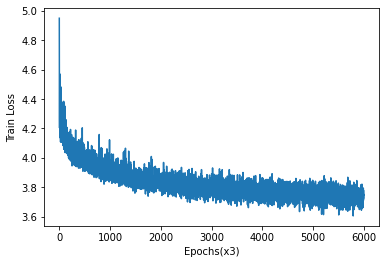

In [18]:
import matplotlib.pyplot as plt

plt.plot(np.arange(6000), train_losses)
plt.xlabel("Epochs(x3)")
plt.ylabel("Train Loss")
plt.show()

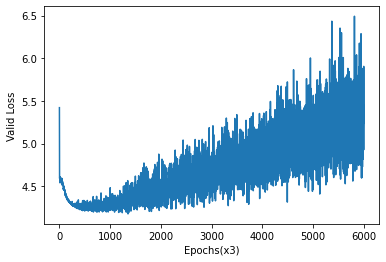

In [19]:
plt.plot(np.arange(6000), valid_losses)
plt.xlabel("Epochs(x3)")
plt.ylabel("Valid Loss")
plt.show()